### ViT

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn.parameter import Parameter
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms, models
from torchinfo import summary
import matplotlib.pyplot as plt
import time

## Building the Vision Transformer (ViT)

In [2]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
      Summary:
        1. We consider an image of size 224 x 224 and having 3 channels
        2. Our patch size is taken to be as 16
        3. Consider 3 channels RGB
        4. embed_dim : 768 (16 x 16 x 3) # desired output channel shape
        5. We have 196 patches in the image as (num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]))
      Returns:
        Output Shape: 1 (batch size) x 196 (num_patches) x 768 (embed_dim)
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (img_size,img_size) # tuple of (224,224)
        patch_size = (patch_size,patch_size) # tuple of (16,16)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x) # Size([1, 768, 14, 14])
        x = x.flatten(2)# Size([1, 768, 196])
        x = x.transpose(1, 2) # Size([1, 196, 768])
        return x

In [3]:
class Mlp(nn.Module):
    """ MLP as used in Vision Transformer,
      Returns:
        Output Shape: 1 (batch size) x 196 (num_patches) x 768 (embed_dim)
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        """
        Forward pass for the MLP module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_patches, embed_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_patches, embed_dim).
        """
        x = self.fc1(x)

        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)

        x = self.drop(x)
        return x


In [4]:
class Attention(nn.Module):
    """
    Multi-Head Self Attention Module.

    Args:
        dim (int): Dimension of input features.
        num_heads (int): Number of attention heads. Default is 8.
        qkv_bias (bool): If True, add bias to the linear layers for Q, K, V. Default is False.
        qk_scale (float): Custom scale for QK. Default is None (uses 1/sqrt(head_dim)).
        attn_drop (float): Dropout rate for attention weights. Default is 0.0.
        proj_drop (float): Dropout rate for output projection. Default is 0.0.
    """
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads  # Dimension per head
        self.scale = qk_scale or head_dim ** -0.5  # Scaling factor for QK (will be 1/sqrt(head_dim))

        # Linear layer to project input into queries, keys, and values
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)  # Linear layer for Q, K, V
        self.attn_drop = nn.Dropout(attn_drop)  # Dropout for attention weights
        self.proj = nn.Linear(dim, dim)  # Output projection layer
        self.proj_drop = nn.Dropout(proj_drop)  # Dropout for output projection

    def forward(self, x):
        """
        Forward pass for the attention module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_tokens, dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_tokens, dim).
        """
        B, N, C = x.shape  # Batch size, number of patches, and feature dimension

        # Project input to Q, K, V and reshape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)

        # Split into queries, keys, and values
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to values and reshape
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)

        # Project the output and apply dropout
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


In [5]:
class Block(nn.Module):
    """
    Transformer Block consisting of Multi-Head Self Attention and MLP layers.

    Args:
        dim (int): Dimension of input features.
        num_heads (int): Number of attention heads.
        mlp_ratio (float): Ratio of hidden units in MLP to input dimension. Default is 4.0.
        qkv_bias (bool): If True, add bias to the linear layers for Q, K, V. Default is False.
        qk_scale (float): Custom scale for QK. Default is None (uses 1/sqrt(head_dim)).
        drop (float): Dropout rate for both attention and MLP layers. Default is 0.0.
        attn_drop (float): Dropout rate for attention weights. Default is 0.0.
        drop_path (float): Dropout rate for stochastic depth (DropPath). Default is 0.0.
        act_layer (torch.nn.Module): Activation function. Default is nn.GELU.
        norm_layer (torch.nn.Module): Normalization layer. Default is nn.LayerNorm.
    """
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()  # DropPath for stochastic depth
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        """
        Forward pass for the Transformer Block.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_patches, dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_patches, dim).
        """
        # Self-attention and normalization
        x = x + self.drop_path(self.attn(self.norm1(x)))

        # MLP and normalization
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x



In [6]:
class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage.

    Args:
        img_size (int): Input image size. Default is 224.
        patch_size (int): Patch size for patch embeddings. Default is 16.
        in_chans (int): Number of input channels. Default is 3 (RGB images).
        num_classes (int): Number of output classes. Default is 1000.
        embed_dim (int): Dimensionality of the token embeddings. Default is 768.
        depth (int): Number of encoder blocks. Default is 12.
        num_heads (int): Number of attention heads. Default is 12.
        mlp_ratio (float): Ratio of MLP hidden units to embed_dim. Default is 4.0.
        qkv_bias (bool): If True, add bias to the QKV linear layers. Default is False.
        qk_scale (float): Scale factor for QK if not provided, computed as 1/sqrt(head_dim).
        drop_rate (float): Dropout rate for all layers. Default is 0.0.
        attn_drop_rate (float): Dropout rate for attention weights. Default is 0.0.
        drop_path_rate (float): Dropout rate for stochastic depth. Default is 0.0.
        norm_layer (torch.nn.Module): Normalization layer. Default is nn.LayerNorm.
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        # Patch Embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # Class token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Stochastic depth decay rule
        # torch.linspace generates a 1-dimensional tensor of depth equally spaced values between 0 and drop_path_rate, inclusive.
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        # Encoder Blocks (12)
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])

        # Final Layer Normalization
        self.norm = norm_layer(embed_dim)

        # Classifier head
        """self.head:
              Output layer for classification tasks, mapping the final transformer output to class probabilities or
              feature representations based on num_classes"""
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        """
        Forward pass through the feature extraction part of the Vision Transformer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, embed_dim).
        """
        B = x.shape[0]

        # Patch Embedding
        x = self.patch_embed(x)

        # Adding class token and positional embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # Concatenate class token and patch embeddings
        x = x + self.pos_embed  # adds the positional embeddings
        x = self.pos_drop(x)

        # Transformer Blocks
        for blk in self.blocks:
            x = blk(x)

        # Final Layer Normalization
        x = self.norm(x)

        # Return only the class token
        return x[:, 0]

    def forward(self, x):
        """
        Forward pass through the entire Vision Transformer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_chans, img_size, img_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes) if num_classes > 0,
                        otherwise (batch_size, embed_dim).
        """
        # Feature extraction through the Vision Transformer
        x = self.forward_features(x)

        # Classification head
        x = self.head(x)

        return x


## Loading the CIFAR Data   

In [7]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
val_dataset, test_dataset = random_split(test_dataset, [5000, 5000])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

100%|██████████| 170498071/170498071 [00:03<00:00, 49123964.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
def train_loop(train_dataloader,val_dataloader,model,loss_fn,optimizer,batch_size,epoch):
    train_start_time = time.time()

    train_size=len(train_dataloader.dataset)
    num_batches=len(train_dataloader)
    loss_tot=0
    train_correct=0

    for batch,(X,y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model.train()
        pred=model(X)
        loss=loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_tot+=loss.item()
        
        model.eval()
        pred=model(X)
        train_correct_each = (pred.argmax(1) == y).type(torch.float).sum().item()
        train_acc=train_correct_each/(y.shape[0])
        train_correct+=train_correct_each
        loss, current = loss.item(), batch * batch_size + len(X)

        train_end_time = time.time() 
        train_duration = train_end_time - train_start_time 

        print(f"\rEpoch {epoch+1} : Training loss: {loss:>7f} - Training Accuracy: {train_acc:>7f}  [{current:>5d}/{train_size:>5d}] - Training Time: {train_duration:.2f}s", end="")

    loss_avg=loss_tot/num_batches
    train_acc = train_correct/train_size

    val_loss = 0
    val_correct=0
    val_size=len(val_dataloader.dataset)

    model.eval()
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= len(val_dataloader)
    val_acc=val_correct/val_size

    print(f"\rEpoch {epoch+1} : Training loss: {loss_avg:>7f} - Training Accuracy: {train_acc:>7f} - Validation loss: {val_loss:>7f} - Validation accuracy: {val_acc:>7f} - Training Time: {train_duration:.2f}s")
    print(end='')
    return loss_avg, train_acc, val_loss, val_acc


def test_loop(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    model.eval()
    num_batches=len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc=correct/size
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

model=VisionTransformer(num_classes=1000).to(device)
learning_rate = 1e-3
batch_size = batch_size
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 1000]                 152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          590,592
├─Dropout: 1-2                           [1, 197, 768]             --
├─ModuleList: 1-3                        --                        --
│    └─Block: 2-2                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             1,536
│    │    └─Attention: 3-2               [1, 197, 768]             2,360,064
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─LayerNorm: 3-4               [1, 197, 768]             1,536
│    │    └─Mlp: 3-5                     [1, 197, 768]             4,722,432
│    │    └─Identity: 3-6                [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768] 

## Training

In [9]:
loss_history = {'train': [], 'val': []}
accuracy_history = {'train': [], 'val': []}

best_val_loss = float('inf')
patience = 10  # How many epochs to wait after last improvement
patience_counter = 0 
min_delta=0.001

for t in range(epochs):
    print(f"Epoch {t+1}",end=" ")
    train_loss, train_accuracy, val_loss, val_accuracy =train_loop(train_loader,val_loader, model, loss_fn, optimizer,batch_size,t)
    # test_loop(test_loader, model, loss_fn)
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    accuracy_history['train'].append(train_accuracy)
    accuracy_history['val'].append(val_accuracy)

    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
        torch.save(model.state_dict(), 'best_model_weights.pth')
    else:
        patience_counter += 1 
    
    if patience_counter >= patience:
        print(f"\nStopping early at epoch {t+1} with restoring best weights")
        epochs=t+1
        break 
    

Epoch 1 : Training loss: 2.157278 - Training Accuracy: 0.204000 - Validation loss: 2.070907 - Validation accuracy: 0.196400 - Training Time: 1190.04s
Epoch 2 : Training loss: 2.111059 - Training Accuracy: 0.200900 - Validation loss: 2.100061 - Validation accuracy: 0.195400 - Training Time: 1193.76s
Epoch 3 : Training loss: 2.105723 - Training Accuracy: 0.200880 - Validation loss: 2.099683 - Validation accuracy: 0.183000 - Training Time: 1195.86s
Epoch 4 : Training loss: 2.087968 - Training Accuracy: 0.203040 - Validation loss: 2.054756 - Validation accuracy: 0.208000 - Training Time: 1194.79s
Epoch 5 : Training loss: 2.122783 - Training Accuracy: 0.192700 - Validation loss: 2.088969 - Validation accuracy: 0.175400 - Training Time: 1193.78s


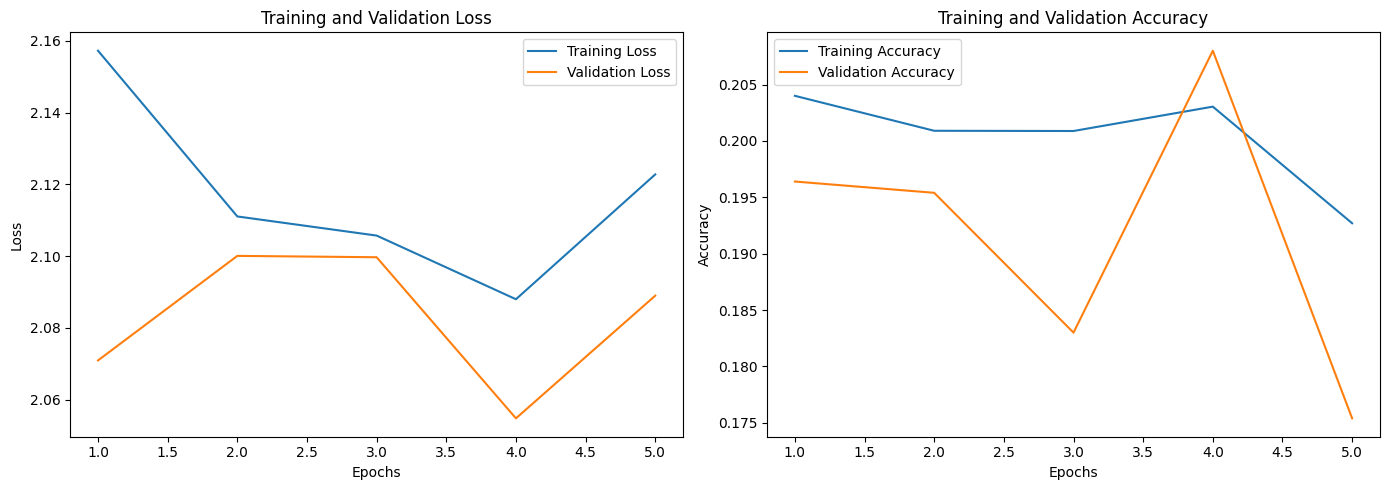

In [10]:
plt.figure(figsize=(14, 5))
eplist=[]
for i in range(epochs):
    eplist.append(i+1)
plt.subplot(1, 2, 1)
plt.plot(eplist, loss_history['train'], label='Training Loss')
plt.plot(eplist, loss_history['val'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eplist, accuracy_history['train'], label='Training Accuracy')
plt.plot(eplist, accuracy_history['val'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()